# Load libraries & parameters

In [1]:
%matplotlib inline
import itertools as it
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
import seaborn as sns
import scipy.cluster.hierarchy as spc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, recall_score
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import datetime
import pickle
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import confusion_matrix

# parameter
null_percentage = 0.1
test_ratio = 0.2
random_state = 1

epochs = 200
neurons = [32, 18, 18, 32]
k_best = 120
m_subsets = 3
assert k_best % m_subsets == 0
n_features = int(k_best/m_subsets)

Using TensorFlow backend.


# Feature correlation selection

In [2]:
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
import random

# Feature correlation selection
class FCS(PermutationProblem):

    def __init__(self, correlation, variables, subsets):
        super(FCS, self).__init__()

        self.correlation = correlation
        self.subsets = subsets
        self.n_features = int(variables/subsets)
        
        # Minimization to find most independent between variable 
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = variables
        self.number_of_objectives = 1
        self.number_of_constraints = 0

    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0

        for i in range(self.subsets):

          end = self.n_features*(i+1)
          start = end - self.n_features

          comb = list(it.combinations(solution.variables[start:end-1], 2))

          for j in comb:
              fitness += self.correlation[j[0]][j[1]]

          solution.objectives[0] = fitness

        return solution

    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
    
    def get_name(self):
        return 'Feature correlation selection'

# Load dataset

In [3]:
#  reading the data
data = pd.read_csv('shared/uci-secom.csv')
data = data.drop(['Time'], axis = 1)
data.loc[data['Fault'] == -1, 'Fault'] = 0

# getting the shape of the data
print(data.shape)
data.head()

(1567, 591)


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [4]:
output_labels = data['Fault'].value_counts()
fault_fraction = output_labels[1]/float(output_labels[0])
print('fault_fraction', fault_fraction)
print(output_labels)
data.describe()

fault_fraction 0.0710868079289132
0    1463
1     104
Name: Fault, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


# Preprocessing

## Data cleaning

In [5]:
def drop_constant_column(dataframe):
    for column in dataframe.columns:
        unique = dataframe[column].unique()
        unique = unique[~np.isnan(unique)]
        if len(unique) == 1:
            dataframe.drop(column,inplace=True,axis=1)
    return dataframe

# Drop columns with constant value
data = drop_constant_column(data)

# Only keep columns with NaN values below percentage
data = data.loc[:, data.isnull().mean() < null_percentage]
data.head()

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


## Data imputation

In [6]:
data.replace(np.nan, 0, inplace = True)
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputer.fit(data)
# data = pd.DataFrame(imputer.transform(data), columns=data.columns)
print("Is there any null?", data.isnull().any().any())
data.head()

Is there any null? False


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


## Data normalization

In [7]:
from sklearn import preprocessing
#returns a numpy array
x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)

np.save('shared/data_preprocessed', data)
data.head()

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,0.903043,0.900774,0.944916,0.379841,0.001220,0.755216,0.965785,0.905880,0.542479,0.358362,...,0.112244,0.981758,0.024759,0.033493,0.023796,0.141186,0.000000,0.000000,0.000000,0.0
1,0.922365,0.866043,0.963354,0.393982,0.000744,0.791811,0.969673,0.903526,0.412315,0.228669,...,0.068396,0.984504,0.046790,0.052632,0.044759,0.221387,0.251564,0.209790,0.282386,0.0
2,0.873750,0.899348,0.944345,0.457065,0.001355,0.738771,0.965008,0.871529,0.448168,0.411832,...,0.050771,0.972538,0.032942,0.037321,0.031968,0.629073,0.605757,0.517483,0.112383,1.0
3,0.890467,0.871229,0.949797,0.244894,0.001185,0.806460,0.946345,0.898454,0.319564,0.359499,...,0.043312,0.978815,0.021611,0.023923,0.020688,0.309942,0.186483,0.153846,0.100153,0.0
4,0.903434,0.879298,0.964626,0.357067,0.001376,0.776750,0.960342,0.907450,0.392050,0.315131,...,0.069148,0.941546,1.000000,1.000000,1.000000,0.309942,0.186483,0.153846,0.100153,0.0


## Dataset splitting

In [8]:
# split data by class
fail_test_set = data[data['Fault'] == 1]
pass_set = data[data['Fault'] == 0]

n_pass_test_set = 210

# randomly select and add pass data to become test set
train_set, pass_test_set = train_test_split(pass_set, test_size = n_pass_test_set, random_state = random_state)
test_set = pd.concat([fail_test_set, pass_test_set])

# shuffle test set
test_set = test_set.reindex(np.random.permutation(test_set.index))

x_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1]

x_test = test_set.iloc[:, :-1]
y_test = test_set.iloc[:, -1]

print('Train set', x_train.shape)
print(y_train.value_counts())
print('Test set', x_test.shape)
print(y_test.value_counts())
print("Is there any null?", data.isnull().any().any())

np.save('shared/x_train', x_train)
np.save('shared/y_train', y_train)
np.save('shared/x_test', x_test)
np.save('shared/y_test', y_test)

Train set (1253, 422)
0.0    1253
Name: Fault, dtype: int64
Test set (314, 422)
0.0    210
1.0    104
Name: Fault, dtype: int64
Is there any null? False


# Edge deployment

## Select k features (most correlated to output)

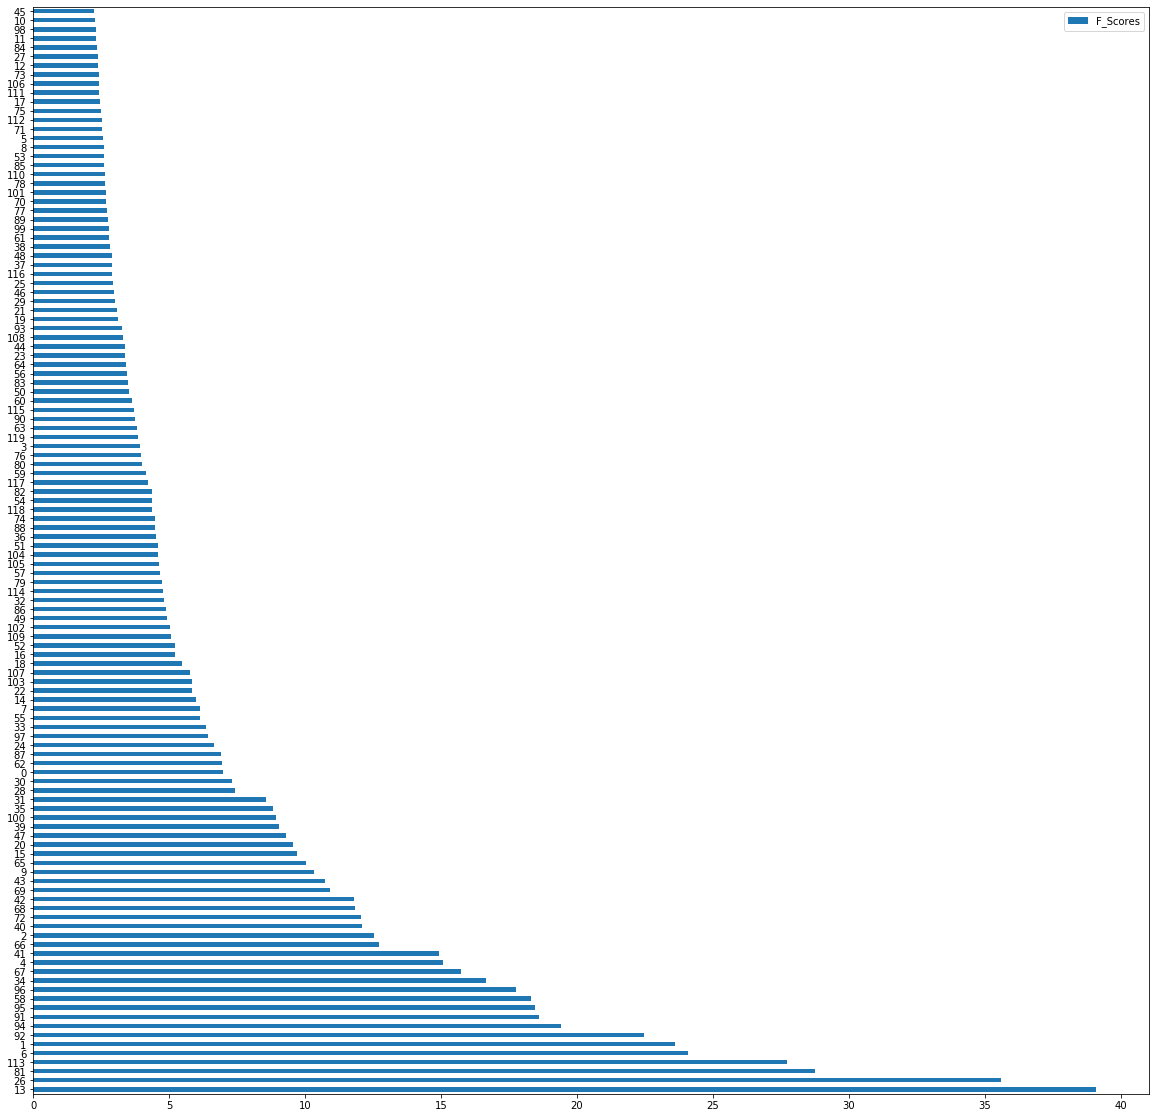

In [9]:
# using all data
x_all = data.iloc[:, :-1]
y_all = data.iloc[:, -1]

selector = SelectKBest(f_classif, k=k_best)
k_features = selector.fit_transform(x_all, y_all)
k_best_index = x_all.columns[selector.get_support()]
np.save('shared/k_best_index', k_best_index)

k_best_names = x_all.columns.values[selector.get_support()]
k_best_scores = selector.scores_[selector.get_support()]
k_best_names_scores = list(zip(k_best_names, k_best_scores))
ns_df = pd.DataFrame(data = k_best_names_scores, columns=['Feature', 'F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feature'], ascending = [False, True])
ns_df_sorted.plot(kind='barh', figsize=(20, 20))
plt.savefig('shared/F_Scores.png')
plt.show()

In [10]:
data_importance = data.loc[:, k_best_index]
data_importance.head()

,14,21,22,25,26,27,28,31,32,33,...,479,484,488,510,511,543,545,573,575,577
0,0.407019,0.242124,0.797675,0.647599,0.863698,0.398104,0.824561,0.732474,0.789717,0.407474,...,0.026741,0.496259,0.053242,0.143240,0.000000,0.325,0.338144,0.116901,0.150986,0.112244
1,0.519520,0.238978,0.712274,0.938169,0.981245,0.964903,0.878334,0.711244,0.803998,0.419772,...,0.020413,0.000000,0.194921,0.313269,0.000000,0.325,0.338144,0.093239,0.102807,0.068396
2,0.486824,0.238104,0.738940,0.948944,0.988650,0.989554,0.861788,0.749022,0.802593,0.370910,...,0.042200,0.000000,0.192235,0.533299,0.244275,0.325,0.338144,0.057042,0.077769,0.050771
3,0.491403,0.235237,0.724308,0.950029,0.976130,0.955045,0.807873,0.703792,0.804048,0.371762,...,0.055476,0.306714,0.000000,0.251524,0.000000,0.325,0.338144,0.050282,0.055956,0.043312
4,0.540562,0.234118,0.720752,0.931950,0.969992,0.949862,0.806589,0.681209,0.817460,0.375566,...,0.048339,0.463317,0.750039,0.327954,0.000000,0.325,0.338144,0.073099,0.090288,0.069148


## Generate m subsets of n features (least correlated to each other)

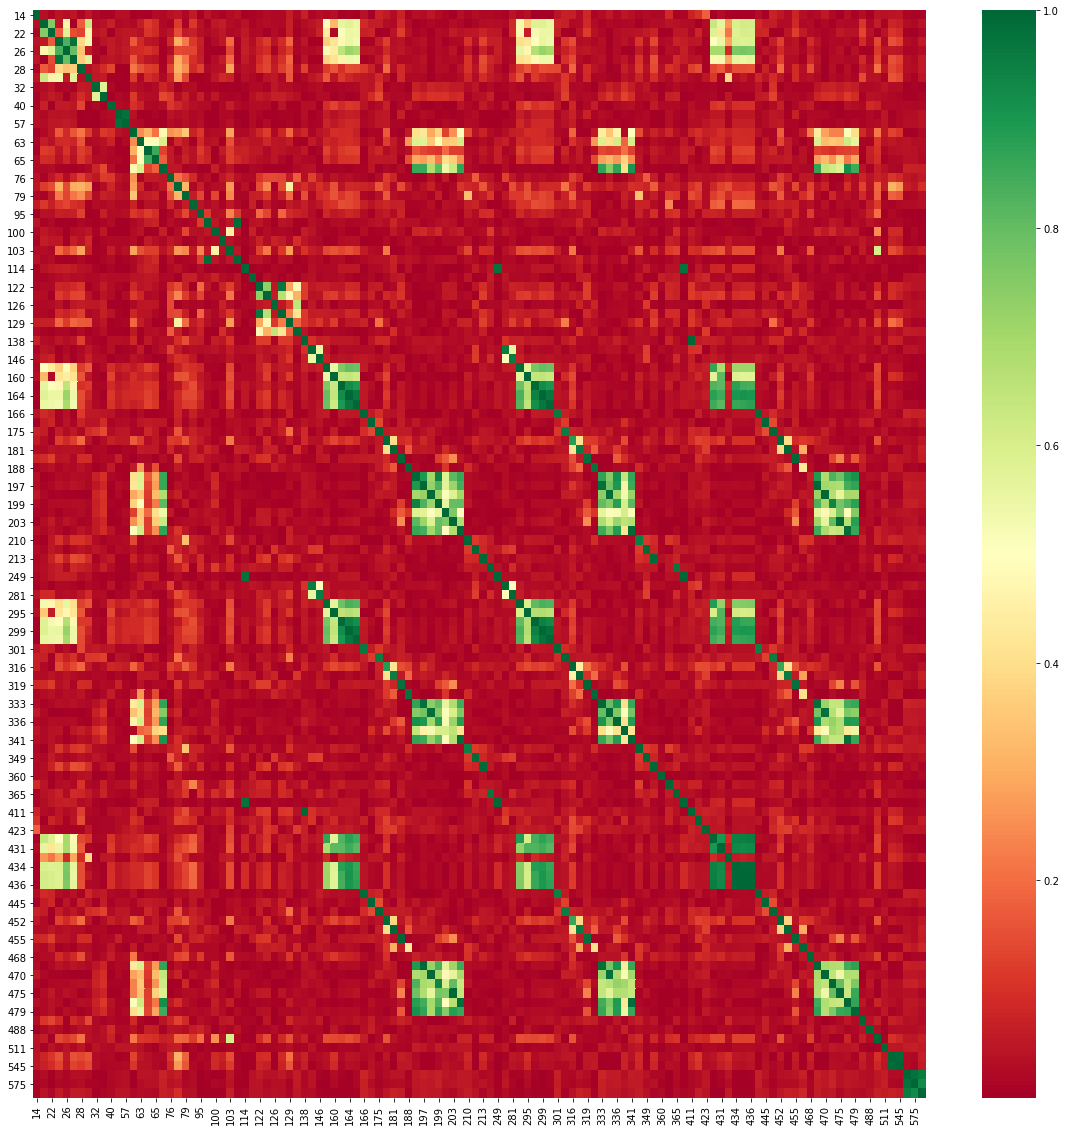

In [11]:
#get correlations of each features in dataset
corrmat = abs(data_importance.corr())
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(abs(data_importance[top_corr_features].corr()),annot=False,cmap="RdYlGn")
plt.savefig('shared/P_Scores.png')

In [12]:
problem = FCS(abs(corrmat.values), k_best, m_subsets)

algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=PermutationSwapMutation(1.0 / k_best),
        crossover=PMXCrossover(0.8),
        selection=BinaryTournamentSelection(),
        termination_criterion=StoppingByEvaluations(max=200000)
    )

algorithm.observable.register(observer=PrintObjectivesObserver(10000))

algorithm.run()
result = algorithm.get_result()

print('Algorithm: {}'.format(algorithm.get_name()))
print('Problem: {}'.format(problem.get_name()))
print('Solution: {}'.format(result.variables))
print('Fitness: {}'.format(result.objectives[0]))
print('Computing time: {}'.format(algorithm.total_computing_time))

2020-01-09 19:24:51,516 [MainThread  ] [INFO ]  Evaluations: 10000. fitness: [156.52419611072983]
2020-01-09 19:25:04,806 [MainThread  ] [INFO ]  Evaluations: 20000. fitness: [154.44331837660954]
2020-01-09 19:25:19,488 [MainThread  ] [INFO ]  Evaluations: 30000. fitness: [153.61908509653335]
2020-01-09 19:25:32,825 [MainThread  ] [INFO ]  Evaluations: 40000. fitness: [153.3363807766328]
2020-01-09 19:25:46,850 [MainThread  ] [INFO ]  Evaluations: 50000. fitness: [153.3363807766328]
2020-01-09 19:26:01,147 [MainThread  ] [INFO ]  Evaluations: 60000. fitness: [153.2656264711791]
2020-01-09 19:26:14,293 [MainThread  ] [INFO ]  Evaluations: 70000. fitness: [152.71922467660025]
2020-01-09 19:26:27,426 [MainThread  ] [INFO ]  Evaluations: 80000. fitness: [152.44324752803473]
2020-01-09 19:26:40,655 [MainThread  ] [INFO ]  Evaluations: 90000. fitness: [152.26716686960424]
2020-01-09 19:26:53,736 [MainThread  ] [INFO ]  Evaluations: 100000. fitness: [152.26716686960407]
2020-01-09 19:27:07,27

Algorithm: Genetic algorithm
Problem: Feature correlation selection
Solution: [103, 116, 72, 14, 95, 106, 101, 58, 29, 37, 30, 55, 67, 113, 102, 94, 112, 18, 88, 97, 80, 62, 98, 86, 83, 71, 9, 104, 108, 117, 0, 12, 13, 7, 78, 92, 69, 6, 79, 68, 41, 4, 63, 20, 66, 110, 105, 35, 93, 25, 64, 87, 2, 73, 90, 75, 59, 100, 19, 107, 76, 61, 118, 8, 27, 109, 96, 26, 99, 60, 115, 44, 49, 33, 21, 15, 53, 65, 42, 51, 70, 43, 39, 50, 77, 82, 81, 10, 114, 32, 31, 17, 84, 22, 36, 57, 46, 47, 23, 111, 5, 91, 54, 56, 16, 3, 45, 74, 1, 24, 40, 48, 11, 38, 34, 119, 89, 28, 85, 52]
Fitness: 151.65951426858638
Computing time: 268.21703338623047


In [13]:
features_allsubset = data.columns[result.variables]
feature_subsets = []
subset = []
for i in features_allsubset:
    subset.append(str(i))
    if len(subset) == n_features:
        feature_subsets.append(subset)
        subset = []
        
print(feature_subsets)
np.save('shared/feature_subsets', feature_subsets)

[['117', '130', '80', '16', '105', '120', '115', '63', '31', '39', '32', '60', '75', '127', '116', '104', '126', '20', '98', '107', '89', '67', '108', '95', '92', '79', '10', '118', '122', '131', '0', '14', '15', '8', '87', '102', '77', '7', '88', '76'], ['44', '4', '68', '22', '74', '124', '119', '37', '103', '27', '70', '96', '2', '81', '100', '83', '64', '114', '21', '121', '84', '66', '132', '9', '29', '123', '106', '28', '113', '65', '129', '47', '54', '35', '23', '17', '58', '71', '45', '56'], ['78', '46', '41', '55', '86', '91', '90', '11', '128', '34', '33', '19', '93', '24', '38', '62', '50', '51', '25', '125', '6', '101', '59', '61', '18', '3', '48', '82', '1', '26', '43', '53', '12', '40', '36', '133', '99', '30', '94', '57']]


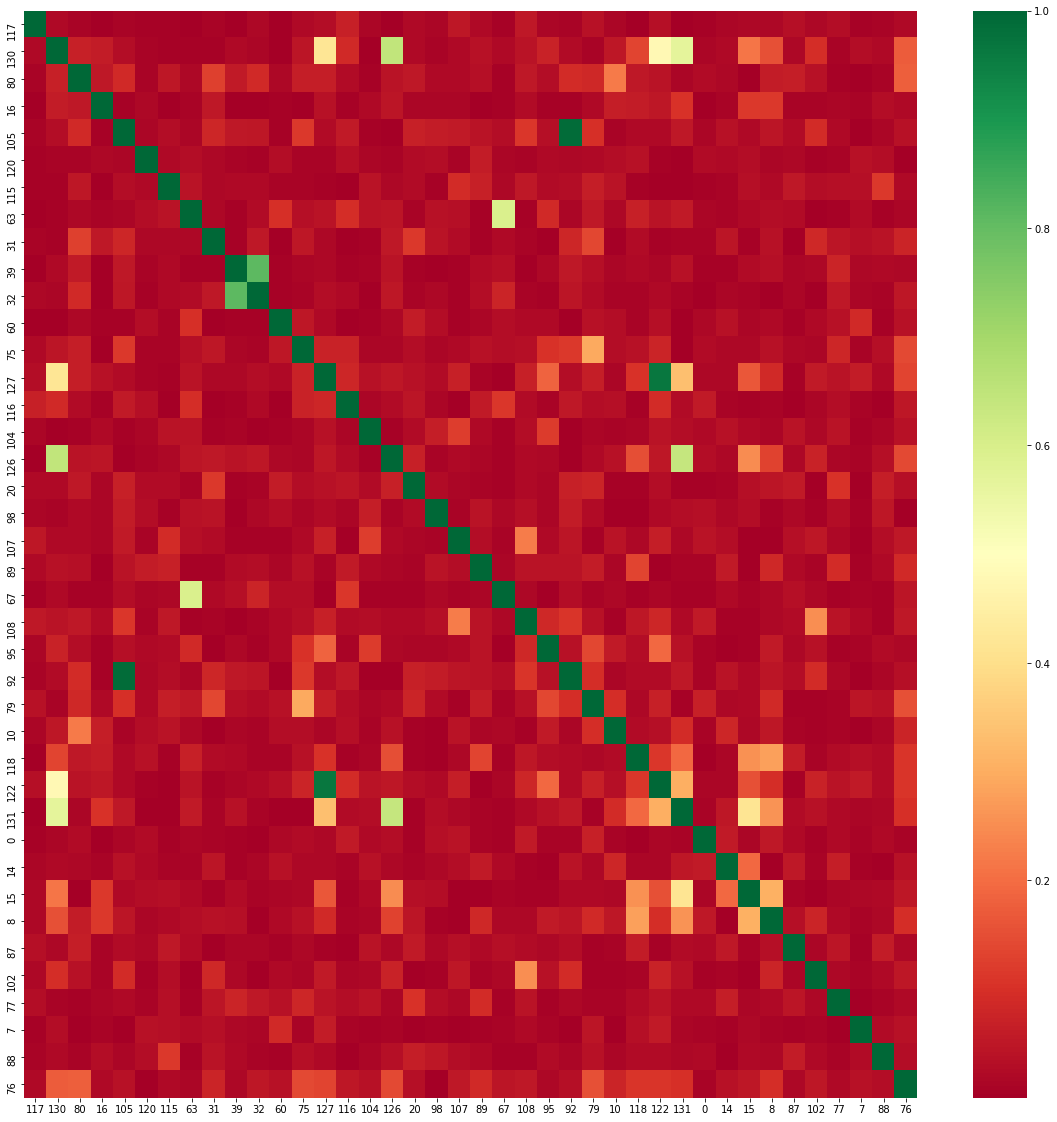

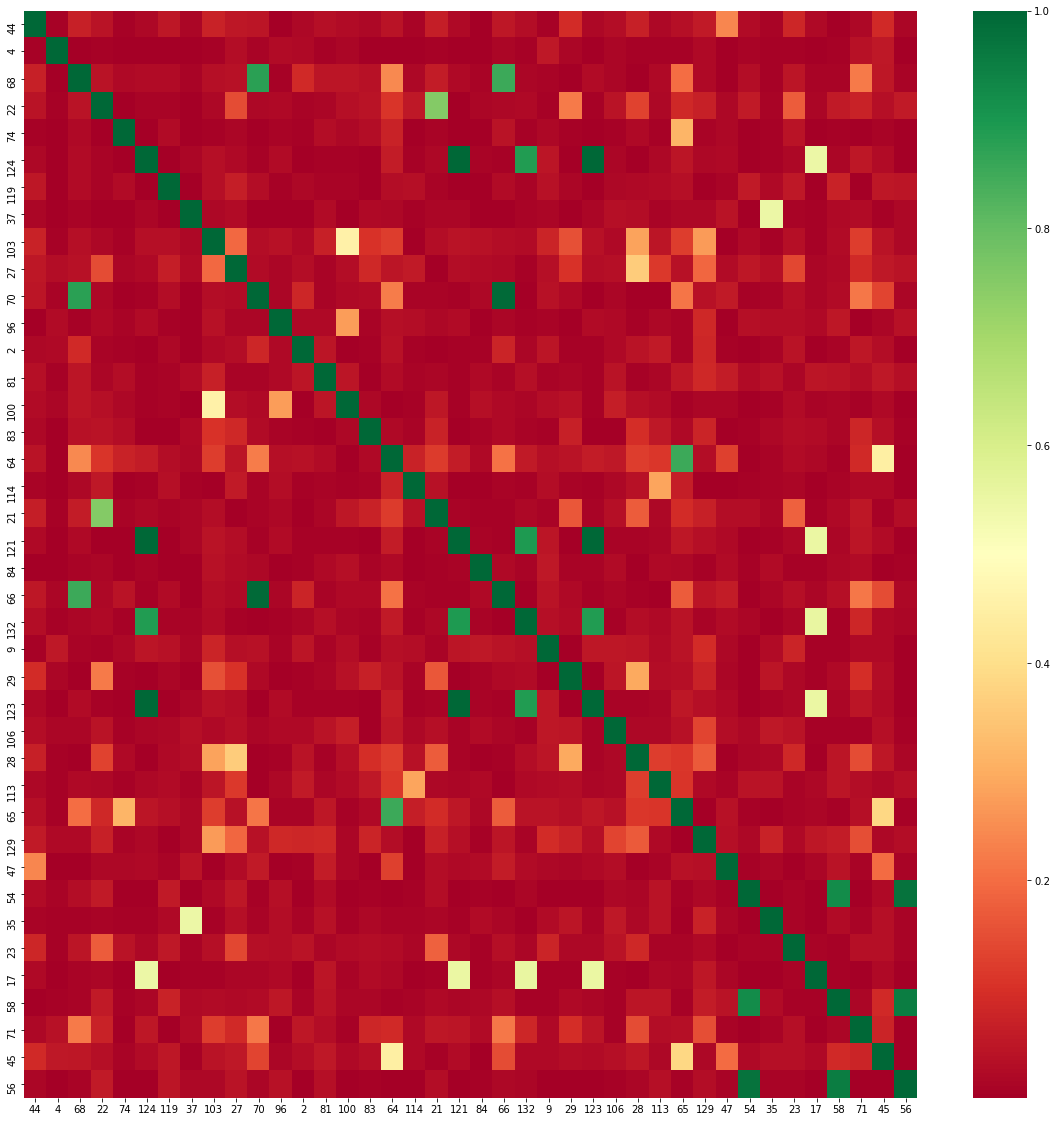

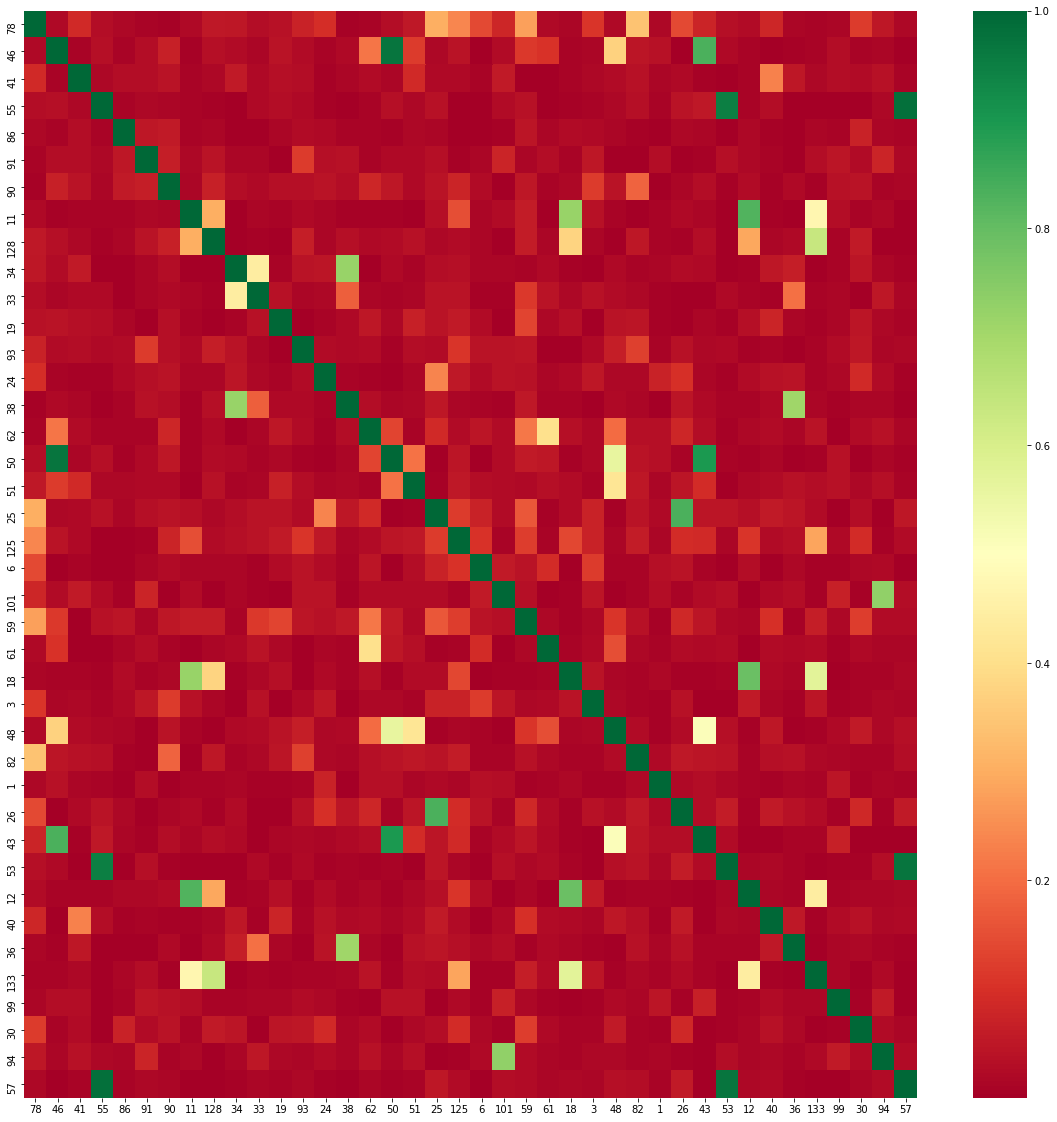

In [14]:
for subset_i in range(m_subsets):
    temp = data.loc[:, feature_subsets[subset_i]]
    corrmat = abs(temp.corr())
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(abs(temp[top_corr_features].corr()),annot=False,cmap="RdYlGn")
    plt.savefig('edge-m{}/P_Scores.png'.format(subset_i+1))

# Training each subset

In [15]:
# Train on each edge
for subset_i in range(m_subsets):
    print(feature_subsets[subset_i])
    x_train_subset = x_train.loc[:, feature_subsets[subset_i]]
    x_test_subset = x_test.loc[:, feature_subsets[subset_i]]
    
    clf_name = 'AutoEncoder'
    clf = AutoEncoder(epochs=epochs, hidden_neurons=neurons, contamination=fault_fraction, validation_size=0, random_state=random_state)
    clf.fit(x_train_subset)
    pickle.dump(clf, open('edge-m{}/autoencoder.h5'.format(subset_i+1), 'wb'))

# Train on Cloud-k
x_train_subset = x_train.loc[:, k_best_index]
x_test_subset = x_test.loc[:, k_best_index]
clf_name = 'AutoEncoder'
clf = AutoEncoder(epochs=epochs, hidden_neurons=neurons, contamination=fault_fraction, validation_size=0, random_state=random_state)
clf.fit(x_train_subset)
pickle.dump(clf, open('cloud-k/autoencoder.h5', 'wb'))

# Train on Cloud-all
x_train_subset = x_train
x_test_subset = x_test
clf_name = 'AutoEncoder'
clf = AutoEncoder(epochs=epochs, hidden_neurons=neurons, contamination=fault_fraction, validation_size=0, random_state=random_state)
clf.fit(x_train_subset)
pickle.dump(clf, open('cloud-all/autoencoder.h5', 'wb'))

['117', '130', '80', '16', '105', '120', '115', '63', '31', '39', '32', '60', '75', '127', '116', '104', '126', '20', '98', '107', '89', '67', '108', '95', '92', '79', '10', '118', '122', '131', '0', '14', '15', '8', '87', '102', '77', '7', '88', '76']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1312      

1253/1253 [==============================] - 0s 146us/step - loss: 2.0839
Epoch 69/200
1253/1253 [==============================] - 0s 143us/step - loss: 2.0690
Epoch 70/200
1253/1253 [==============================] - 0s 139us/step - loss: 2.0403
Epoch 71/200
1253/1253 [==============================] - 0s 143us/step - loss: 2.0378
Epoch 72/200
1253/1253 [==============================] - 0s 142us/step - loss: 2.0093
Epoch 73/200
1253/1253 [==============================] - 0s 142us/step - loss: 1.9957
Epoch 74/200
1253/1253 [==============================] - 0s 142us/step - loss: 1.9778
Epoch 75/200
1253/1253 [==============================] - 0s 139us/step - loss: 1.9594
Epoch 76/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.9601
Epoch 77/200
1253/1253 [==============================] - 0s 142us/step - loss: 1.9362
Epoch 78/200
1253/1253 [==============================] - 0s 149us/step - loss: 1.9300
Epoch 79/200
1253/1253 [==============================] 

1253/1253 [==============================] - 0s 135us/step - loss: 1.2800
Epoch 162/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.2790
Epoch 163/200
1253/1253 [==============================] - 0s 136us/step - loss: 1.2720
Epoch 164/200
1253/1253 [==============================] - 0s 142us/step - loss: 1.2678
Epoch 165/200
1253/1253 [==============================] - 0s 147us/step - loss: 1.2630
Epoch 166/200
1253/1253 [==============================] - 0s 156us/step - loss: 1.2602
Epoch 167/200
1253/1253 [==============================] - 0s 132us/step - loss: 1.2582
Epoch 168/200
1253/1253 [==============================] - 0s 139us/step - loss: 1.2506
Epoch 169/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.2531
Epoch 170/200
1253/1253 [==============================] - 0s 143us/step - loss: 1.2454
Epoch 171/200
1253/1253 [==============================] - 0s 133us/step - loss: 1.2418
Epoch 172/200
1253/1253 [=====================

1253/1253 [==============================] - 0s 160us/step - loss: 4.3687
Epoch 29/200
1253/1253 [==============================] - 0s 154us/step - loss: 4.1770
Epoch 30/200
1253/1253 [==============================] - 0s 150us/step - loss: 4.0353
Epoch 31/200
1253/1253 [==============================] - 0s 141us/step - loss: 3.8814
Epoch 32/200
1253/1253 [==============================] - 0s 146us/step - loss: 3.7550
Epoch 33/200
1253/1253 [==============================] - 0s 158us/step - loss: 3.6486
Epoch 34/200
1253/1253 [==============================] - 0s 158us/step - loss: 3.5144
Epoch 35/200
1253/1253 [==============================] - 0s 156us/step - loss: 3.4273
Epoch 36/200
1253/1253 [==============================] - 0s 149us/step - loss: 3.3360
Epoch 37/200
1253/1253 [==============================] - 0s 163us/step - loss: 3.2633
Epoch 38/200
1253/1253 [==============================] - 0s 149us/step - loss: 3.1821
Epoch 39/200
1253/1253 [==============================] 

1253/1253 [==============================] - 0s 162us/step - loss: 1.4847
Epoch 122/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.4837
Epoch 123/200
1253/1253 [==============================] - 0s 142us/step - loss: 1.4702
Epoch 124/200
1253/1253 [==============================] - 0s 149us/step - loss: 1.4634
Epoch 125/200
1253/1253 [==============================] - 0s 165us/step - loss: 1.4623
Epoch 126/200
1253/1253 [==============================] - 0s 164us/step - loss: 1.4585
Epoch 127/200
1253/1253 [==============================] - 0s 162us/step - loss: 1.4480
Epoch 128/200
1253/1253 [==============================] - 0s 162us/step - loss: 1.4375
Epoch 129/200
1253/1253 [==============================] - 0s 166us/step - loss: 1.4303
Epoch 130/200
1253/1253 [==============================] - 0s 159us/step - loss: 1.4264
Epoch 131/200
1253/1253 [==============================] - 0s 161us/step - loss: 1.4221
Epoch 132/200
1253/1253 [=====================

Epoch 1/200
1253/1253 [==============================] - 1s 450us/step - loss: 125.7097
Epoch 2/200
1253/1253 [==============================] - 0s 177us/step - loss: 83.2123
Epoch 3/200
1253/1253 [==============================] - 0s 145us/step - loss: 61.1872
Epoch 4/200
1253/1253 [==============================] - 0s 150us/step - loss: 45.2969
Epoch 5/200
1253/1253 [==============================] - 0s 150us/step - loss: 36.0554
Epoch 6/200
1253/1253 [==============================] - 0s 154us/step - loss: 29.6927
Epoch 7/200
1253/1253 [==============================] - 0s 150us/step - loss: 24.6168
Epoch 8/200
1253/1253 [==============================] - 0s 137us/step - loss: 21.2122
Epoch 9/200
1253/1253 [==============================] - 0s 150us/step - loss: 18.0695
Epoch 10/200
1253/1253 [==============================] - 0s 152us/step - loss: 15.6524
Epoch 11/200
1253/1253 [==============================] - 0s 162us/step - loss: 13.5251
Epoch 12/200
1253/1253 [================

1253/1253 [==============================] - 0s 150us/step - loss: 1.7092
Epoch 95/200
1253/1253 [==============================] - 0s 148us/step - loss: 1.7075
Epoch 96/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.6956
Epoch 97/200
1253/1253 [==============================] - 0s 170us/step - loss: 1.6825
Epoch 98/200
1253/1253 [==============================] - 0s 145us/step - loss: 1.6744
Epoch 99/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.6596
Epoch 100/200
1253/1253 [==============================] - 0s 154us/step - loss: 1.6559
Epoch 101/200
1253/1253 [==============================] - 0s 154us/step - loss: 1.6422
Epoch 102/200
1253/1253 [==============================] - 0s 172us/step - loss: 1.6394
Epoch 103/200
1253/1253 [==============================] - 0s 215us/step - loss: 1.6267
Epoch 104/200
1253/1253 [==============================] - 0s 276us/step - loss: 1.6224
Epoch 105/200
1253/1253 [==========================

1253/1253 [==============================] - 0s 155us/step - loss: 1.1776
Epoch 188/200
1253/1253 [==============================] - 0s 155us/step - loss: 1.1739
Epoch 189/200
1253/1253 [==============================] - 0s 161us/step - loss: 1.1727
Epoch 190/200
1253/1253 [==============================] - 0s 147us/step - loss: 1.1702
Epoch 191/200
1253/1253 [==============================] - 0s 151us/step - loss: 1.1667
Epoch 192/200
1253/1253 [==============================] - 0s 153us/step - loss: 1.1648
Epoch 193/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.1614
Epoch 194/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.1598
Epoch 195/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.1573
Epoch 196/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.1562
Epoch 197/200
1253/1253 [==============================] - 0s 150us/step - loss: 1.1512
Epoch 198/200
1253/1253 [=====================

1253/1253 [==============================] - 0s 151us/step - loss: 3.3089
Epoch 58/200
1253/1253 [==============================] - 0s 151us/step - loss: 3.2715
Epoch 59/200
1253/1253 [==============================] - 0s 167us/step - loss: 3.2895
Epoch 60/200
1253/1253 [==============================] - 0s 144us/step - loss: 3.2122
Epoch 61/200
1253/1253 [==============================] - 0s 150us/step - loss: 3.1463
Epoch 62/200
1253/1253 [==============================] - 0s 166us/step - loss: 3.1342
Epoch 63/200
1253/1253 [==============================] - 0s 143us/step - loss: 3.1060
Epoch 64/200
1253/1253 [==============================] - 0s 150us/step - loss: 3.0854
Epoch 65/200
1253/1253 [==============================] - 0s 160us/step - loss: 3.0524
Epoch 66/200
1253/1253 [==============================] - 0s 148us/step - loss: 3.0306
Epoch 67/200
1253/1253 [==============================] - 0s 160us/step - loss: 2.9987
Epoch 68/200
1253/1253 [==============================] 

1253/1253 [==============================] - 0s 142us/step - loss: 1.6920
Epoch 151/200
1253/1253 [==============================] - 0s 146us/step - loss: 1.6702
Epoch 152/200
1253/1253 [==============================] - 0s 156us/step - loss: 1.6643
Epoch 153/200
1253/1253 [==============================] - 0s 158us/step - loss: 1.6557
Epoch 154/200
1253/1253 [==============================] - 0s 163us/step - loss: 1.6452
Epoch 155/200
1253/1253 [==============================] - 0s 171us/step - loss: 1.6345
Epoch 156/200
1253/1253 [==============================] - 0s 152us/step - loss: 1.6364
Epoch 157/200
1253/1253 [==============================] - 0s 152us/step - loss: 1.6214
Epoch 158/200
1253/1253 [==============================] - 0s 158us/step - loss: 1.6201
Epoch 159/200
1253/1253 [==============================] - 0s 155us/step - loss: 1.6039
Epoch 160/200
1253/1253 [==============================] - 0s 155us/step - loss: 1.6032
Epoch 161/200
1253/1253 [=====================

1253/1253 [==============================] - 0s 163us/step - loss: 11.8664
Epoch 20/200
1253/1253 [==============================] - 0s 177us/step - loss: 11.2011
Epoch 21/200
1253/1253 [==============================] - 0s 157us/step - loss: 10.9842
Epoch 22/200
1253/1253 [==============================] - 0s 160us/step - loss: 10.2550
Epoch 23/200
1253/1253 [==============================] - 0s 158us/step - loss: 10.0515
Epoch 24/200
1253/1253 [==============================] - 0s 239us/step - loss: 9.5756
Epoch 25/200
1253/1253 [==============================] - 0s 174us/step - loss: 9.3177
Epoch 26/200
1253/1253 [==============================] - 0s 198us/step - loss: 9.2529
Epoch 27/200
1253/1253 [==============================] - 0s 166us/step - loss: 9.0122
Epoch 28/200
1253/1253 [==============================] - 0s 213us/step - loss: 8.6940
Epoch 29/200
1253/1253 [==============================] - 0s 172us/step - loss: 8.3251
Epoch 30/200
1253/1253 [===========================

1253/1253 [==============================] - 0s 169us/step - loss: 3.0852
Epoch 114/200
1253/1253 [==============================] - 0s 162us/step - loss: 3.1272
Epoch 115/200
1253/1253 [==============================] - 0s 163us/step - loss: 3.0814
Epoch 116/200
1253/1253 [==============================] - 0s 163us/step - loss: 3.0525
Epoch 117/200
1253/1253 [==============================] - 0s 168us/step - loss: 3.0275
Epoch 118/200
1253/1253 [==============================] - 0s 166us/step - loss: 3.0087
Epoch 119/200
1253/1253 [==============================] - 0s 190us/step - loss: 3.0094
Epoch 120/200
1253/1253 [==============================] - 0s 162us/step - loss: 2.9628
Epoch 121/200
1253/1253 [==============================] - 0s 161us/step - loss: 2.8940
Epoch 122/200
1253/1253 [==============================] - 0s 166us/step - loss: 2.8655
Epoch 123/200
1253/1253 [==============================] - 0s 169us/step - loss: 2.8970
Epoch 124/200
1253/1253 [=====================

# Prediction

In [ ]:
# Server
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.models import load_model

x_test_subset = 0 # receive
title = 'edge-m1/autoencoder.h5'
clf = load_model('edge-m1/autoencoder.h5')
# clf = load_model('edge-m2/autoencoder.h5')
# clf = load_model('edge-m3/autoencoder.h5')
# clfc = load_model('cloud-k/autoencoder.h5')
# clfc = load_model('cloud-all/autoencoder.h5')

y_test_pred = clf.predict(x_test_subset)

In [ ]:
# Client
import datetime
import numpy as np

m_subsets = 3
x_test = np.load('x_test.npy')
feature_subsets = np.load('feature_subsets.npy')
k_best_index = np.load('k_best_index.npy')

# Test on each edge
subset_i = 0
x_test_subset = x_test.loc[:, feature_subsets[subset_i]]
start = datetime.datetime.now()
#     send
end = datetime.datetime.now()
interval = end - start
    
# # Test on Cloud-k
# x_test_subset = x_test.loc[:, k_best_index]
# start = datetime.datetime.now()
# #     send
# end = datetime.datetime.now()
# interval = end - start

# # Test on Cloud-all
# x_test_subset = x_test
# start = datetime.datetime.now()
# #     send
# end = datetime.datetime.now()
# interval = end - start

In [16]:

# # get the prediction on the test data
# start = datetime.datetime.now()
# y_test_pred = clf.predict(x_test_subset)  # outlier labels (0 or 1)
# end = datetime.datetime.now()
# interval_test = end - start

# # Confusion matrix and classification report

# matrix = confusion_matrix(y_test, y_test_pred)
# # matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# sns.heatmap(matrix,annot=True,cbar=False, fmt='g')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion matrix of subset {}'.format(subset_i+1))
# plt.savefig('subset{}-confusionmatrix.png'.format(subset_i))

# y_test_scores = clf.decision_function(x_test_subset)  # outlier scores
# print('Subset {}'.format(subset_i+1))
# print(y_test.value_counts())
# print('roc_auc_score', roc_auc_score(y_test, y_test_scores))
# print('interval test', interval_test)
# # evaluate and print the results
# print("\nOn Test Data:")
# evaluate_print(clf_name, y_test, y_test_scores)
# print(classification_report(y_test, y_test_pred))

## ROC graph

In [17]:
# subset0_y_test_pred = np.load('edge-m1/y_test_pred.npy')
# subset1_y_test_pred = np.load('edge-m2/y_test_pred.npy')
# subset2_y_test_pred = np.load('edge-m3/y_test_pred.npy')
# subset80_y_test_pred = np.load('subset80/y_test_pred.npy')
# subset90_y_test_pred = np.load('subset90/y_test_pred.npy')

# subset0_y_test_scores = np.load('edge-m1/y_test_scores.npy')
# subset1_y_test_scores = np.load('edge-m2/y_test_scores.npy')
# subset2_y_test_scores = np.load('edge-m3/y_test_scores.npy')
# subset80_y_test_scores = np.load('cloud-k/y_test_scores.npy')
# subset90_y_test_scores = np.load('cloud-all/y_test_scores.npy')

# fpr0, tpr0, thresholds0 = roc_curve(y_test, subset0_y_test_scores)
# fpr1, tpr1, thresholds1 = roc_curve(y_test, subset1_y_test_scores)
# fpr2, tpr2, thresholds2 = roc_curve(y_test, subset2_y_test_scores)
# fpr80, tpr80, thresholds80 = roc_curve(y_test, subset80_y_test_scores)
# fpr90, tpr90, thresholds90 = roc_curve(y_test, subset90_y_test_scores)

# plt.plot(fpr0, tpr0, label='ROC curve Edge-m1')
# plt.plot(fpr1, tpr1, label='ROC curve Edge-m2')
# plt.plot(fpr2, tpr2, label='ROC curve Edge-m3')
# plt.plot(fpr80, tpr80, label='ROC curve Cloud-k')
# plt.plot(fpr90, tpr90, label='ROC curve Cloud-all')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves.png')

# plt.plot(fpr80, tpr80, label='ROC curve Cloud-k')
# plt.plot(fpr90, tpr90, label='ROC curve Cloud-all')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves-cloud.png')

# plt.plot(fpr0, tpr0, label='ROC curve Edge-m1')
# plt.plot(fpr1, tpr1, label='ROC curve Edge-m2')
# plt.plot(fpr2, tpr2, label='ROC curve Edge-m3')
# plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.xlim([-0.02, 1])
# plt.ylim([0, 1.02])
# plt.legend(loc="lower right")
# plt.savefig('shared/roccurves-edge.png')